# Covid prediction Random Forest Confirmed Cases

### Loading libraries

In [35]:
import pandas as pd
import pandas as pd 
import random

In [36]:
import math
import time
import datetime
import operator 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [37]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

In [38]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-dark')
#print(plt.style.available)
%matplotlib inline

from sklearn import metrics

In [39]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

In [40]:
import warnings
warnings.filterwarnings("ignore")

### Preparation for predictions

#### Data Loading

In [41]:
#dataset
covid_df= pd.read_csv("corona_pred_china.csv")
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0,0,0,0,"6,940,432","1,092","6355,7","5,24","28,800"
1,2020-01-22,Japan,Asia,2,0,0,2,"127,463,611","377,835","337,4",0,"28,200"
2,2020-01-22,Macao,Asia,1,0,0,1,"453,125",28,"16183,0","4,86","19,400"
3,2020-01-22,South Korea,Asia,1,0,0,1,"48,846,823","98,480","496,0",0,"17,800"
4,2020-01-22,Taiwan,Asia,1,0,0,1,"23,036,087","35,980","640,3",0,"23,400"


#### Data transformations

In [42]:
#Converting "Observation Date" into Datetime format
covid_df["ObservationDate"]=pd.to_datetime(covid_df["ObservationDate"])
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811 entries, 0 to 3810
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             3811 non-null   datetime64[ns]
 1   Country                     3811 non-null   object        
 2   Continent                   3811 non-null   object        
 3   Confirmed                   3811 non-null   float64       
 4   Deaths                      3811 non-null   float64       
 5   Recovered                   3811 non-null   float64       
 6   Active Cases                3811 non-null   float64       
 7   Population                  3811 non-null   float64       
 8   Area (sq. mi.)              3811 non-null   float64       
 9   Pop. Density (per sq. mi.)  3811 non-null   object        
 10  Net migration               3811 non-null   object        
 11  GDP ($ per capita)          3811 non-null   float64     

In [43]:
# Changing datatype of Population density and Net Migration columns as float
cols=["Pop. Density (per sq. mi.)","Net migration"]                             
for i in cols:
    covid_df[i]=covid_df[i].str.replace(",","").astype(float)
covid_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811 entries, 0 to 3810
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             3811 non-null   datetime64[ns]
 1   Country                     3811 non-null   object        
 2   Continent                   3811 non-null   object        
 3   Confirmed                   3811 non-null   float64       
 4   Deaths                      3811 non-null   float64       
 5   Recovered                   3811 non-null   float64       
 6   Active Cases                3811 non-null   float64       
 7   Population                  3811 non-null   float64       
 8   Area (sq. mi.)              3811 non-null   float64       
 9   Pop. Density (per sq. mi.)  3811 non-null   float64       
 10  Net migration               3811 non-null   float64       
 11  GDP ($ per capita)          3811 non-null   float64     

In [44]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0,0,0,0,"6,940,432","1,092","63,557",524,"28,800"
1,2020-01-22,Japan,Asia,2,0,0,2,"127,463,611","377,835","3,374",0,"28,200"
2,2020-01-22,Macao,Asia,1,0,0,1,"453,125",28,"161,830",486,"19,400"
3,2020-01-22,South Korea,Asia,1,0,0,1,"48,846,823","98,480","4,960",0,"17,800"
4,2020-01-22,Taiwan,Asia,1,0,0,1,"23,036,087","35,980","6,403",0,"23,400"


In [45]:
# Sorting based on the country names
covid_df = covid_df.sort_values(["Country", "ObservationDate"]).reset_index(drop=True)

In [46]:
covid_df.shape

(3811, 12)

In [47]:
# Calculating days since the first occurance for each country
covid_df['days_since_first']=0
covid_df['previous_Confirmed'] = 0
covid_df['increase_rate'] = 0
previous_Confirmed=0
confirm_difference=0

for i in covid_df.index[1:]:
    if covid_df['Country'][i]==covid_df['Country'][i-1]:
        covid_df.loc[i,'days_since_first']=(covid_df.at[i-1,'days_since_first']+1)
        previous_Confirmed=covid_df.at[i-1,'Confirmed']
        confirm_difference= covid_df.at[i,'Confirmed']-previous_Confirmed
        covid_df.loc[i,'previous_Confirmed']=previous_Confirmed        
        if ((previous_Confirmed!=0) & (confirm_difference>0) ):
            covid_df.loc[i,'increase_rate']=((confirm_difference/previous_Confirmed))       
        else:
            covid_df.loc[i,'increase_rate']=0
    else:
        covid_df.loc[i,'days_since_first'] = 0
        covid_df.loc[i,'previous_Confirmed'] = 0
        covid_df.loc[i,'increase_rate'] = 0  

In [48]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita),days_since_first,previous_Confirmed,increase_rate
0,2020-02-24,Afghanistan,Asia,1,0,0,1,"31,056,997","647,500",480,"2,306",700,0,0,0
1,2020-02-25,Afghanistan,Asia,1,0,0,1,"31,056,997","647,500",480,"2,306",700,1,1,0
2,2020-02-26,Afghanistan,Asia,1,0,0,1,"31,056,997","647,500",480,"2,306",700,2,1,0
3,2020-02-27,Afghanistan,Asia,1,0,0,1,"31,056,997","647,500",480,"2,306",700,3,1,0
4,2020-02-28,Afghanistan,Asia,1,0,0,1,"31,056,997","647,500",480,"2,306",700,4,1,0


In [49]:
# Ensuring that previous confirmed column type is int
covid_df['previous_Confirmed'].astype(int)
covid_df=covid_df[covid_df['increase_rate']>=0]

In [50]:
covid_df.set_index('Country',inplace=True)

#### Check for highest number of confirmed cases in Europe

In [51]:
covid_df[covid_df['Continent'] == "Europe"].groupby('Country').agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'days_since_first': max,  # get the max of days
                }).sort_values(["Confirmed", "days_since_first"]).tail()

,Confirmed,days_since_first
Country,,
Switzerland,"39,168",26
France,"101,887",58
Germany,"136,100",54
Spain,"157,432",50
Italy,"438,821",51


In [52]:
covid_df.columns

Index(['ObservationDate', 'Continent', 'Confirmed', 'Deaths', 'Recovered',
       'Active Cases', 'Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Net migration', 'GDP ($ per capita)',
       'days_since_first', 'previous_Confirmed', 'increase_rate'],
      dtype='object')

In [53]:
covid_df.to_csv("COVID_For_Orange.csv")

### Random Forest Regressor

In [54]:
X=covid_df.copy()
del X['Continent']
del X['ObservationDate']
del X['Deaths']
del X['Recovered']
del X['Active Cases']
del X['GDP ($ per capita)']
#del X['previous_Activecases']
#del X['previous_Death']
#del X['previous_Recovered']



In [55]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3811 entries, Afghanistan to Zimbabwe
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Confirmed                   3811 non-null   float64
 1   Population                  3811 non-null   float64
 2   Area (sq. mi.)              3811 non-null   float64
 3   Pop. Density (per sq. mi.)  3811 non-null   float64
 4   Net migration               3811 non-null   float64
 5   days_since_first            3811 non-null   int64  
 6   previous_Confirmed          3811 non-null   float64
 7   increase_rate               3811 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 268.0+ KB


In [56]:
X["Net migration"].fillna(0, inplace=True)
X["Pop. Density (per sq. mi.)"].fillna(0, inplace=True)

In [57]:
X.isnull().any()

Confirmed                     False
Population                    False
Area (sq. mi.)                False
Pop. Density (per sq. mi.)    False
Net migration                 False
days_since_first              False
previous_Confirmed            False
increase_rate                 False
dtype: bool

In [58]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Confirmed,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed,increase_rate
Confirmed,1.00,0.03,0.01,-0.03,0.01,0.28,1.00,-0.02
Population,0.03,1.00,0.30,-0.07,-0.06,0.15,0.03,-0.02
Area (sq. mi.),0.01,0.30,1.00,-0.10,0.08,0.16,0.01,-0.03
Pop. Density (per sq. mi.),-0.03,-0.07,-0.10,1.00,0.29,0.14,-0.03,-0.05
Net migration,0.01,-0.06,0.08,0.29,1.00,0.13,0.01,-0.01
days_since_first,0.28,0.15,0.16,0.14,0.13,1.00,0.27,-0.08
previous_Confirmed,1.00,0.03,0.01,-0.03,0.01,0.27,1.00,-0.02
increase_rate,-0.02,-0.02,-0.03,-0.05,-0.01,-0.08,-0.02,1.00


In [59]:
# Pick only features that are correlated more than 0.2
y = X['Confirmed']     

In [60]:
print(X.shape)
X.head()

(3811, 8)


,Confirmed,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed,increase_rate
Country,,,,,,,,
Afghanistan,1,"31,056,997","647,500",480,"2,306",0,0,0
Afghanistan,1,"31,056,997","647,500",480,"2,306",1,1,0
Afghanistan,1,"31,056,997","647,500",480,"2,306",2,1,0
Afghanistan,1,"31,056,997","647,500",480,"2,306",3,1,0
Afghanistan,1,"31,056,997","647,500",480,"2,306",4,1,0


In [61]:
# To get rid of +e format
pd.options.display.float_format = '{:20,.0f}'.format

#### Train Test Split

In [62]:
X.drop(['Confirmed'], axis=1, inplace=True)


# Break off validation set from training data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=1)

In [63]:
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
# print(f"X_validate shape is {X_validate.shape}")
print(f"y_train is {y_train.shape}")
# print(f"y_validate shape is {y_validate.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (3239, 7)
X_test shape is (572, 7)
y_train is (3239,)
y_test shape is (572,)


## Random Forest

#### Defining the model and checking the best score

In [64]:
#DEFINE YOUR REGRESSOR and THE PARAMETERS GRID

regressor = RandomForestRegressor()
parameters = {"criterion": ['mse'], 
              "n_estimators":[10, 100, 400], 
              "min_samples_leaf": [0.1, 1, 5, 10, 20, 50], 
              "random_state" : [1]
            #  "max_features": "auto"
            # "oob_score ": TRUE
             }

In [65]:
#DEFINE YOUR GRIDSEARCH 
gs = GridSearchCV(regressor, parameters, cv=3) #with no params it reduces to a CV

gs = gs.fit(X_train.to_numpy(),y_train.to_numpy())

In [66]:
#summarize the results of your GRIDSEARCH
print('***GRIDSEARCH RESULTS***')
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']


***GRIDSEARCH RESULTS***
Best score: 0.982507 using {'criterion': 'mse', 'min_samples_leaf': 1, 'n_estimators': 400, 'random_state': 1}


In [67]:
columns = np.asarray(X.columns)
#columns = np.asarray([columns])
from sklearn import tree
r = tree.export_text(gs.best_estimator_.estimators_[0],feature_names=columns.tolist(), max_depth=3)
print(r)

|--- previous_Confirmed <= 8925.50
|   |--- previous_Confirmed <= 2679.00
|   |   |--- previous_Confirmed <= 587.00
|   |   |   |--- previous_Confirmed <= 164.50
|   |   |   |   |--- truncated branch of depth 21
|   |   |   |--- previous_Confirmed >  164.50
|   |   |   |   |--- truncated branch of depth 14
|   |   |--- previous_Confirmed >  587.00
|   |   |   |--- previous_Confirmed <= 1199.50
|   |   |   |   |--- truncated branch of depth 11
|   |   |   |--- previous_Confirmed >  1199.50
|   |   |   |   |--- truncated branch of depth 9
|   |--- previous_Confirmed >  2679.00
|   |   |--- previous_Confirmed <= 5708.00
|   |   |   |--- previous_Confirmed <= 4532.50
|   |   |   |   |--- truncated branch of depth 6
|   |   |   |--- previous_Confirmed >  4532.50
|   |   |   |   |--- truncated branch of depth 5
|   |   |--- previous_Confirmed >  5708.00
|   |   |   |--- Area (sq. mi.) <= 5639710.00
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- Area (sq. mi.) >  5639710.00

In [68]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

####  Training the model

In [69]:
#we establish the model with the best estimator according to Gridsearch results
gs = gs.best_estimator_ 

gs = gs.fit(X_train.to_numpy(),y_train.to_numpy())

In [70]:
#Returns the coefficient of determination R^2 of the prediction.
#Explained variance score: 1 is perfect prediction
gs.score(X_test.to_numpy(), y_test.to_numpy())

0.9950354977045082

#### Testing the model

In [71]:
y_pred = gs.predict(X_test.to_numpy())

In [72]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred}).reset_index(drop=True)
df

,Actual,Predicted
0,133,131
1,1,1
2,109,92
3,1,1
4,10,10
...,...,...
567,1,1
568,134,132
569,4,4
570,1,1


#### Evaluation results

In [73]:
print("explained_variance_score: ",explained_variance_score(y_test, y_pred))

explained_variance_score:  0.9950547759271776


In [74]:
print("MAE train: ", metrics.mean_absolute_error(y_train.to_numpy(), gs.predict(X_train.to_numpy()))) 
print("MSE train: ",metrics.mean_squared_error(y_train.to_numpy(), gs.predict(X_train.to_numpy())))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train.to_numpy(), gs.predict(X_train.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_train.to_numpy(), gs.predict(X_train.to_numpy()))))

print("MAE test: ", metrics.mean_absolute_error(y_test.to_numpy(), gs.predict(X_test.to_numpy()))) 
print("MSE test: ",metrics.mean_squared_error(y_test.to_numpy(), gs.predict(X_test.to_numpy())))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test.to_numpy(), gs.predict(X_test.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_test.to_numpy(), gs.predict(X_test.to_numpy()))))

MAE train:  12.55647376739714
MSE train:  12739.658144235762
RMSE train:  112.8700941092713
r2:  0.9992367123517645
MAE test:  14.575479161227033
MSE test:  8219.474125974813
RMSE test:  90.6613154877802
r2:  0.99751466039578


## Random Forest Regression -  For different countries

In [101]:
import plotly.io as pio

In [102]:
plt.style.use('dark_background')

### Using Kaggle dataset to cross check the results of future prediction 

In [75]:
covid_df_kaggle= pd.read_csv("covid_19_data_Kaggle.csv")

In [76]:
covid_df_kaggle["ObservationDate"]=pd.to_datetime(covid_df_kaggle["ObservationDate"])

In [77]:
covid_df_kaggle.shape

(13850, 8)

### Random Forest Regression - France

In [82]:
covid_df_kaggle_France = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "France"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [83]:
covid_df_kaggle_France_plt = covid_df_kaggle_France[covid_df_kaggle_France['ObservationDate'] <= '2020-03-26'].reset_index(drop=True)

In [84]:
filter_condn = (covid_df_kaggle_France['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_France['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_France = covid_df_kaggle_France[filter_condn].reset_index(drop=True)
covid_df_kaggle_France

X_France_df = X[X.index == "France"].copy()
X_France_test = X_France_df.head().copy()
X_France_test=X_France_test.reset_index(drop=True)
X_France_test['days_since_first'] = X_France_test['previous_Confirmed'] = X_France_test['increase_rate'] = 0
X_France_test.loc[0,'days_since_first'] =  X_France_df["days_since_first"].iloc[-1]+1
X_France_test.loc[0,'increase_rate']=X_France_df["increase_rate"].iloc[-1]+1
X_France_test.loc[0,'previous_Confirmed'] = y[y.index == "France"].max()

X_France_test['increase_rate']=X_France_df["increase_rate"].max()


for i in range(0,5):
    X_France_test.loc[i,'days_since_first'] = X_France_test.loc[0,'days_since_first'] + i

X_France_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_France_test.iloc[i].to_numpy()]))
    X_France_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_France_test['predicted_infections']= pred.iloc[:, 0] 

X_France_test["ObservationDate"] = covid_df_kaggle_France["ObservationDate"]
covid_df_kaggle_France_plt["predicted_infections"] = covid_df_kaggle_France_plt["Confirmed"] 

covid_df_kaggle_France_plt.iloc[-5,4] = X_France_test.loc[0,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-4,4] = X_France_test.loc[1,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-3,4] = X_France_test.loc[2,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-2,4] = X_France_test.loc[3,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-1,4] = X_France_test.loc[4,'predicted_infections']
    

X_France_test=X_France_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_France_test["Actual infections"] = covid_df_kaggle_France["Confirmed"]
X_France_test["Date"] = covid_df_kaggle_France["ObservationDate"]
X_France_test = X_France_test.iloc[0:5]
X_France_test 

,predicted_infections,Actual infections,Date
0,"18,817","16,214",2020-03-22
1,"23,535","20,123",2020-03-23
2,"28,121","22,622",2020-03-24
3,"32,158","25,600",2020-03-25
4,"38,682","29,551",2020-03-26


(array([737446., 737456., 737463., 737470., 737477., 737485., 737492.,
        737499., 737506.]),
 <a list of 9 Text major ticklabel objects>)

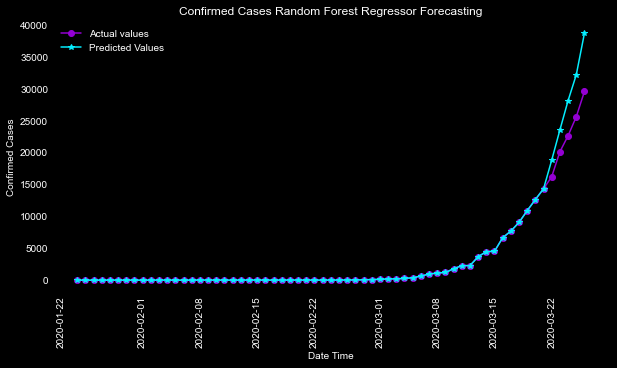

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_France_plt["ObservationDate"],covid_df_kaggle_France_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_France_plt["ObservationDate"],covid_df_kaggle_France_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Spain

In [138]:
covid_df_kaggle_Spain = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Spain"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [139]:
covid_df_kaggle_Spain_plt = covid_df_kaggle_Spain[covid_df_kaggle_Spain['ObservationDate'] <= '2020-03-26'].reset_index(drop=True)

filter_condn = (covid_df_kaggle_Spain['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Spain['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Spain = covid_df_kaggle_Spain[filter_condn].reset_index(drop=True)
covid_df_kaggle_Spain

X_Spain_df = X[X.index == "Spain"].copy()
X_Spain_test = X_Spain_df.head().copy()
X_Spain_test=X_Spain_test.reset_index(drop=True)
X_Spain_test['days_since_first'] = X_Spain_test['previous_Confirmed'] = X_Spain_test['increase_rate'] = 0
X_Spain_test.loc[0,'days_since_first'] =  X_Spain_df["days_since_first"].iloc[-1]+1
X_Spain_test.loc[0,'increase_rate']=X_Spain_df["increase_rate"].iloc[-1]+1
X_Spain_test.loc[0,'previous_Confirmed'] = y[y.index == "Spain"].max()

X_Spain_test['increase_rate']=X_Spain_df["increase_rate"].max()


for i in range(0,5):
    X_Spain_test.loc[i,'days_since_first'] = X_Spain_test.loc[0,'days_since_first'] + i

X_Spain_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Spain_test.iloc[i].to_numpy()]))
    X_Spain_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Spain_test['predicted_infections']= pred.iloc[:, 0] 

X_Spain_test["ObservationDate"] = covid_df_kaggle_Spain["ObservationDate"]
covid_df_kaggle_Spain_plt["predicted_infections"] = covid_df_kaggle_Spain_plt["Confirmed"] 

covid_df_kaggle_Spain_plt.iloc[-5,4] = X_Spain_test.loc[0,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-4,4] = X_Spain_test.loc[1,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-3,4] = X_Spain_test.loc[2,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-2,4] = X_Spain_test.loc[3,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-1,4] = X_Spain_test.loc[4,'predicted_infections']
    

X_Spain_test=X_Spain_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Spain_test["Actual infections"] = covid_df_kaggle_Spain["Confirmed"]
X_Spain_test["Date"] = covid_df_kaggle_Spain["ObservationDate"]
X_Spain_test = X_Spain_test.iloc[0:5]
X_Spain_test 

,predicted_infections,Actual infections,Date
0,"33,399","28,603",2020-03-22
1,"39,150","35,136",2020-03-23
2,"46,449","39,885",2020-03-24
3,"51,092","49,515",2020-03-25
4,"52,245","57,786",2020-03-26


(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.,
        737506.]),
 <a list of 8 Text major ticklabel objects>)

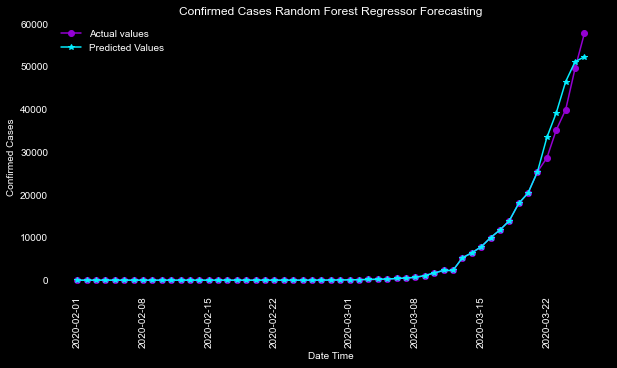

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Spain_plt["ObservationDate"],covid_df_kaggle_Spain_plt["Confirmed"],label="Actual values", color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Spain_plt["ObservationDate"],covid_df_kaggle_Spain_plt["predicted_infections"],color = "#05eeff",label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Germany

In [89]:
covid_df_kaggle_Germany = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Germany"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [90]:
covid_df_kaggle_Germany_plt = covid_df_kaggle_Germany[covid_df_kaggle_Germany['ObservationDate'] <= '2020-03-26'].reset_index(drop=True)

filter_condn = (covid_df_kaggle_Germany['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Germany['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Germany = covid_df_kaggle_Germany[filter_condn].reset_index(drop=True)
covid_df_kaggle_Germany

X_Germany_df = X[X.index == "Germany"].copy()
X_Germany_test = X_Germany_df.head().copy()
X_Germany_test=X_Germany_test.reset_index(drop=True)
X_Germany_test['days_since_first'] = X_Germany_test['previous_Confirmed'] = X_Germany_test['increase_rate'] = 0
X_Germany_test.loc[0,'days_since_first'] =  X_Germany_df["days_since_first"].iloc[-1]+1
X_Germany_test.loc[0,'increase_rate']=X_Germany_df["increase_rate"].iloc[-1]+1
X_Germany_test.loc[0,'previous_Confirmed'] = y[y.index == "Germany"].max()

X_Germany_test['increase_rate']=X_Germany_df["increase_rate"].max()


for i in range(0,5):
    X_Germany_test.loc[i,'days_since_first'] = X_Germany_test.loc[0,'days_since_first'] + i

X_Germany_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Germany_test.iloc[i].to_numpy()]))
    X_Germany_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Germany_test['predicted_infections']= pred.iloc[:, 0] 

X_Germany_test["ObservationDate"] = covid_df_kaggle_Germany["ObservationDate"]
covid_df_kaggle_Germany_plt["predicted_infections"] = covid_df_kaggle_Germany_plt["Confirmed"] 

covid_df_kaggle_Germany_plt.iloc[-5,4] = X_Germany_test.loc[0,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-4,4] = X_Germany_test.loc[1,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-3,4] = X_Germany_test.loc[2,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-2,4] = X_Germany_test.loc[3,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-1,4] = X_Germany_test.loc[4,'predicted_infections']
    

X_Germany_test=X_Germany_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Germany_test["Actual infections"] = covid_df_kaggle_Germany["Confirmed"]
X_Germany_test["Date"] = covid_df_kaggle_Germany["ObservationDate"]
X_Germany_test = X_Germany_test.iloc[0:5]
X_Germany_test 

,predicted_infections,Actual infections,Date
0,"29,107","24,873",2020-03-22
1,"33,874","29,056",2020-03-23
2,"41,471","32,986",2020-03-24
3,"49,317","37,323",2020-03-25
4,"51,765","43,938",2020-03-26


(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.,
        737506.]),
 <a list of 8 Text major ticklabel objects>)

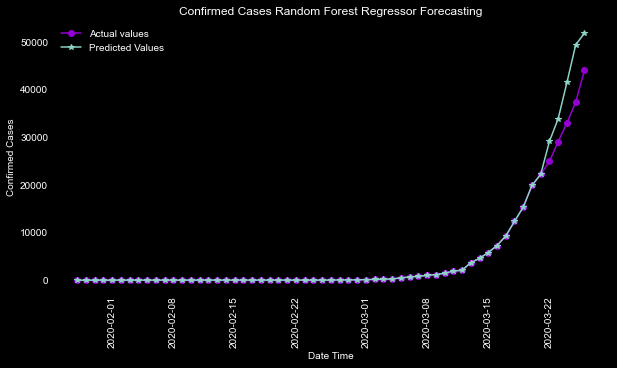

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["Confirmed"],label="Actual values", color = "#9400D3",marker='o')
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["predicted_infections"],label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Switzerland

In [92]:
covid_df_kaggle_Switzerland = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Switzerland"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [93]:
covid_df_kaggle_Switzerland_plt = covid_df_kaggle_Switzerland[covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-03-26'].reset_index(drop=True)

filter_condn = (covid_df_kaggle_Switzerland['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Switzerland = covid_df_kaggle_Switzerland[filter_condn].reset_index(drop=True)
covid_df_kaggle_Switzerland

X_Switzerland_df = X[X.index == "Switzerland"].copy()
X_Switzerland_test = X_Switzerland_df.head().copy()
X_Switzerland_test=X_Switzerland_test.reset_index(drop=True)
X_Switzerland_test['days_since_first'] = X_Switzerland_test['previous_Confirmed'] = X_Switzerland_test['increase_rate'] = 0
X_Switzerland_test.loc[0,'days_since_first'] =  X_Switzerland_df["days_since_first"].iloc[-1]+1
X_Switzerland_test.loc[0,'increase_rate']=X_Switzerland_df["increase_rate"].iloc[-1]+1
X_Switzerland_test.loc[0,'previous_Confirmed'] = y[y.index == "Switzerland"].max()

X_Switzerland_test['increase_rate']=X_Switzerland_df["increase_rate"].max()


for i in range(0,5):
    X_Switzerland_test.loc[i,'days_since_first'] = X_Switzerland_test.loc[0,'days_since_first'] + i

X_Switzerland_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Switzerland_test.iloc[i].to_numpy()]))
    X_Switzerland_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Switzerland_test['predicted_infections']= pred.iloc[:, 0] 

X_Switzerland_test["ObservationDate"] = covid_df_kaggle_Switzerland["ObservationDate"]
covid_df_kaggle_Switzerland_plt["predicted_infections"] = covid_df_kaggle_Switzerland_plt["Confirmed"] 

covid_df_kaggle_Switzerland_plt.iloc[-5,4] = X_Switzerland_test.loc[0,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-4,4] = X_Switzerland_test.loc[1,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-3,4] = X_Switzerland_test.loc[2,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-2,4] = X_Switzerland_test.loc[3,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-1,4] = X_Switzerland_test.loc[4,'predicted_infections']
    

X_Switzerland_test=X_Switzerland_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Switzerland_test["Actual infections"] = covid_df_kaggle_Switzerland["Confirmed"]
X_Switzerland_test["Date"] = covid_df_kaggle_Switzerland["ObservationDate"]
X_Switzerland_test = X_Switzerland_test.iloc[0:5]
X_Switzerland_test 

,predicted_infections,Actual infections,Date
0,"9,265","7,474",2020-03-22
1,"11,960","8,795",2020-03-23
2,"15,833","9,877",2020-03-24
3,"19,015","10,897",2020-03-25
4,"22,989","11,811",2020-03-26


(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.,
        737506.]),
 <a list of 8 Text major ticklabel objects>)

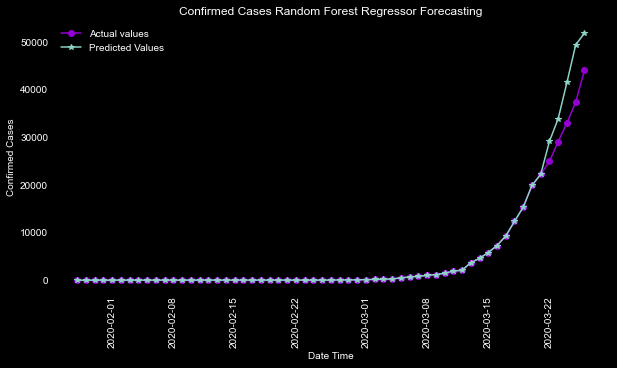

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["Confirmed"],label="Actual values",color = "#9400D3",marker='o')
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["predicted_infections"],label="Predicted Values",marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)

### Random Forest Regression - Italy

In [171]:
covid_df_kaggle_Italy = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Italy"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [172]:
covid_df_kaggle_Italy_plt = covid_df_kaggle_Italy[covid_df_kaggle_Italy['ObservationDate'] <= '2020-03-26'].reset_index(drop=True)

In [173]:
filter_condn = (covid_df_kaggle_Italy['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Italy['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Italy = covid_df_kaggle_Italy[filter_condn].reset_index(drop=True)
covid_df_kaggle_Italy

X_Italy_df = X[X.index == "Italy"].copy()
X_Italy_test = X_Italy_df.head().copy()
X_Italy_test=X_Italy_test.reset_index(drop=True)
X_Italy_test['days_since_first'] = X_Italy_test['previous_Confirmed'] = X_Italy_test['increase_rate'] = 0
X_Italy_test.loc[0,'days_since_first'] =  X_Italy_df["days_since_first"].iloc[-1]+1
X_Italy_test.loc[0,'increase_rate']=X_Italy_df["increase_rate"].iloc[-1]+1
X_Italy_test.loc[0,'previous_Confirmed'] = y[y.index == "Italy"].max()

X_Italy_test['increase_rate']=X_Italy_df["increase_rate"].max()


for i in range(0,5):
    X_Italy_test.loc[i,'days_since_first'] = X_Italy_test.loc[0,'days_since_first'] + i

X_Italy_test

predictions=[]

for i in range(0,5):
    pred=int(gs.predict([X_Italy_test.iloc[i].to_numpy()]))
    X_Italy_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Italy_test['predicted_infections']= pred.iloc[:, 0] 

X_Italy_test["ObservationDate"] = covid_df_kaggle_Italy["ObservationDate"]
covid_df_kaggle_Italy_plt["predicted_infections"] = covid_df_kaggle_Italy_plt["Confirmed"] 

covid_df_kaggle_Italy_plt.iloc[-5,4] = X_Italy_test.loc[0,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-4,4] = X_Italy_test.loc[1,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-3,4] = X_Italy_test.loc[2,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-2,4] = X_Italy_test.loc[3,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-1,4] = X_Italy_test.loc[4,'predicted_infections']
    

X_Italy_test=X_Italy_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Italy_test["Actual infections"] = covid_df_kaggle_Italy["Confirmed"]
X_Italy_test["Date"] = covid_df_kaggle_Italy["ObservationDate"]
X_Italy_test = X_Italy_test.iloc[0:5]
X_Italy_test 


,predicted_infections,Actual infections,Date
0,"52,420","59,138",2020-03-22
1,"52,420","63,927",2020-03-23
2,"52,420","69,176",2020-03-24
3,"52,382","74,386",2020-03-25
4,"52,382","80,589",2020-03-26


(array([737456., 737463., 737470., 737477., 737485., 737492., 737499.,
        737506.]),
 <a list of 8 Text major ticklabel objects>)

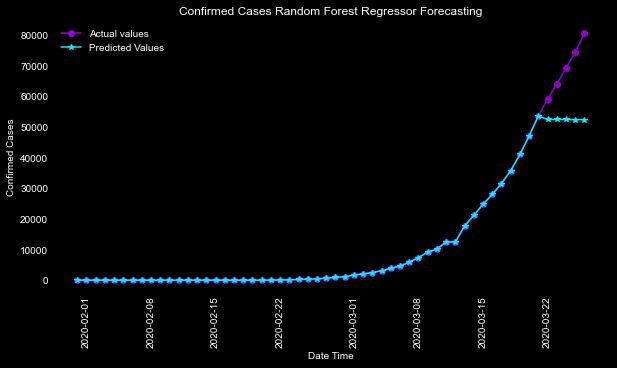

In [174]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Italy_plt["ObservationDate"],covid_df_kaggle_Italy_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Italy_plt["ObservationDate"],covid_df_kaggle_Italy_plt["predicted_infections"],label="Predicted Values", color = "#05eeff", marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases Random Forest Regressor Forecasting")
plt.xticks(rotation=90)